A very basic implementation of an AutoEncoder network for recreating images from the MNIST Dataset in Pytorch. 

Used for understanding the architecture for later extrapolation to anomaly detection applications.

In [3]:
# imports

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF
import random

In [4]:
# loading the MNIST dataset

transform = transforms.ToTensor()

batch_size = 4

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

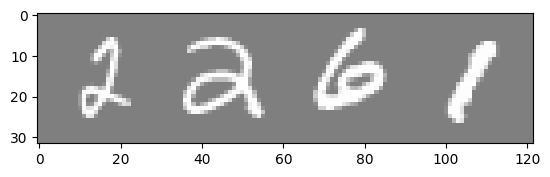

2     2     6     1    


In [5]:
# displaying images (sanity check)

def imshow(img):
    img = img / 2 + 0.5 # unnormalizing the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# fetching a random sample of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# displaying images
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))



High level thought process for the architecture of the autoencoder:

- Original Image: 28x28

    - Encoder Layer 1: 14x14
    - Encoder Layer 2: 2x2
    
    - Decoder Layer 2: 2x2
    - Decoder Layer 3: 14 x 14

- Final Image: 28x28

In [6]:
# defining the auto encoder class

class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 14 * 14),
            torch.nn.ReLU(),
            torch.nn.Linear(14 * 14, 2 * 2),
        )

        # eecoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2 * 2, 14 * 14),
            torch.nn.ReLU(),
            torch.nn.Linear(14 * 14, 28 * 28),
            torch.nn.Sigmoid()  # using sigmoid to get the output in the range [0, 1]
        )

    def forward(self, x):
        x = x.view(x.size(0), -1) # flattening the image
        x = self.encoder(x)
        x = self.decoder(x)
        x=x.view(x.size(0),1,28,28) # reshaping the image
        return x

In [7]:
# some initialization steps

model = AutoEncoder()
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

Epoch [1/20], Step [1000/15000], Loss: 0.0509
Epoch [1/20], Step [2000/15000], Loss: 0.0906
Epoch [1/20], Step [3000/15000], Loss: 0.1292
Epoch [1/20], Step [4000/15000], Loss: 0.1665
Epoch [1/20], Step [5000/15000], Loss: 0.2036
Epoch [1/20], Step [6000/15000], Loss: 0.2397
Epoch [1/20], Step [7000/15000], Loss: 0.2756
Epoch [1/20], Step [8000/15000], Loss: 0.3108
Epoch [1/20], Step [9000/15000], Loss: 0.3461
Epoch [1/20], Step [10000/15000], Loss: 0.3809
Epoch [1/20], Step [11000/15000], Loss: 0.4153
Epoch [1/20], Step [12000/15000], Loss: 0.4488
Epoch [1/20], Step [13000/15000], Loss: 0.4827
Epoch [1/20], Step [14000/15000], Loss: 0.5160
Epoch [1/20], Step [15000/15000], Loss: 0.5497
Epoch [2/20], Step [1000/15000], Loss: 0.0330
Epoch [2/20], Step [2000/15000], Loss: 0.0664
Epoch [2/20], Step [3000/15000], Loss: 0.0998
Epoch [2/20], Step [4000/15000], Loss: 0.1325
Epoch [2/20], Step [5000/15000], Loss: 0.1652
Epoch [2/20], Step [6000/15000], Loss: 0.1978
Epoch [2/20], Step [7000/150

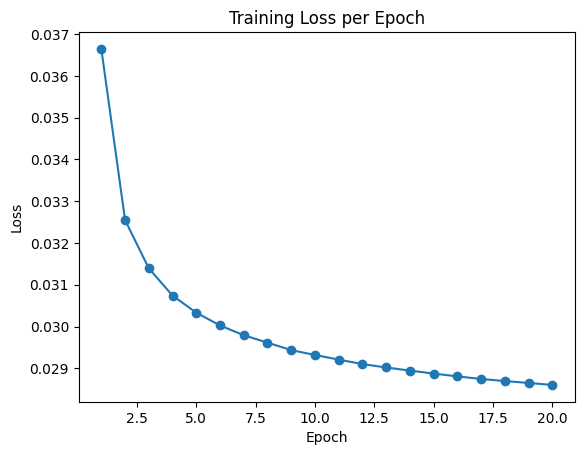

In [8]:
epochs = 20
loss_history = []  # initialize loss history

for epoch in range(epochs):
    running_loss = 0.0
    model.train()  # set the model to training mode

    for i, (images, _) in enumerate(trainloader):
        optimizer.zero_grad()        # clear gradients from previous iteration
        outputs = model(images)
        l = loss(outputs, images)
        l.backward()
        optimizer.step()

        running_loss += l.item()

        if (i+1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss/1000:.4f}')
    
    avg_loss = running_loss / len(trainloader)
    loss_history.append(avg_loss)

plt.figure()
plt.plot(range(1, epochs + 1), loss_history, marker='o')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [9]:
model.eval() # setting the model to evaluation mode
test_loss = 0.0
total_images = 0

with torch.no_grad():
    for images, _ in testloader:
        outputs = model(images)
        loss_val = loss(outputs, images)
        batch_size = images.size(0)
        test_loss += loss_val.item() * batch_size
        total_images += batch_size

test_loss /= total_images
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 0.0293


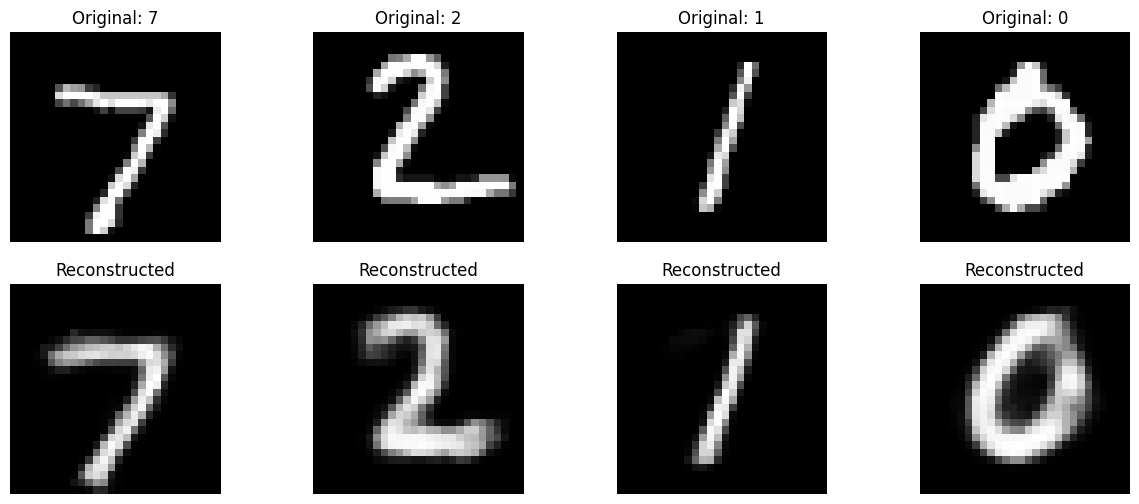

In [10]:
# visualizing the reconstructed images

model.eval()

# Get one batch from the test loader
dataiter = iter(testloader)
images, labels = next(dataiter)

# Get the model's reconstructions of the images
with torch.no_grad():
    outputs = model(images)

num_images = min(8, images.size(0))

fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

for idx in range(num_images):
    # Original image
    img_orig = images[idx].squeeze().numpy()
    ax_orig = axes[0, idx]
    ax_orig.imshow(img_orig, cmap='gray')
    ax_orig.set_title(f"Original: {classes[labels[idx].item()]}")
    ax_orig.axis('off')

    # Reconstructed image
    img_recon = outputs[idx].squeeze().numpy()
    ax_recon = axes[1, idx]
    ax_recon.imshow(img_recon, cmap='gray')
    ax_recon.set_title("Reconstructed")
    ax_recon.axis('off')

plt.show()

Below I try to experiment with feeding the model some pre-blurred images. It is able to actually reduce denoise in these instances, which I thought was quite interesting to see.

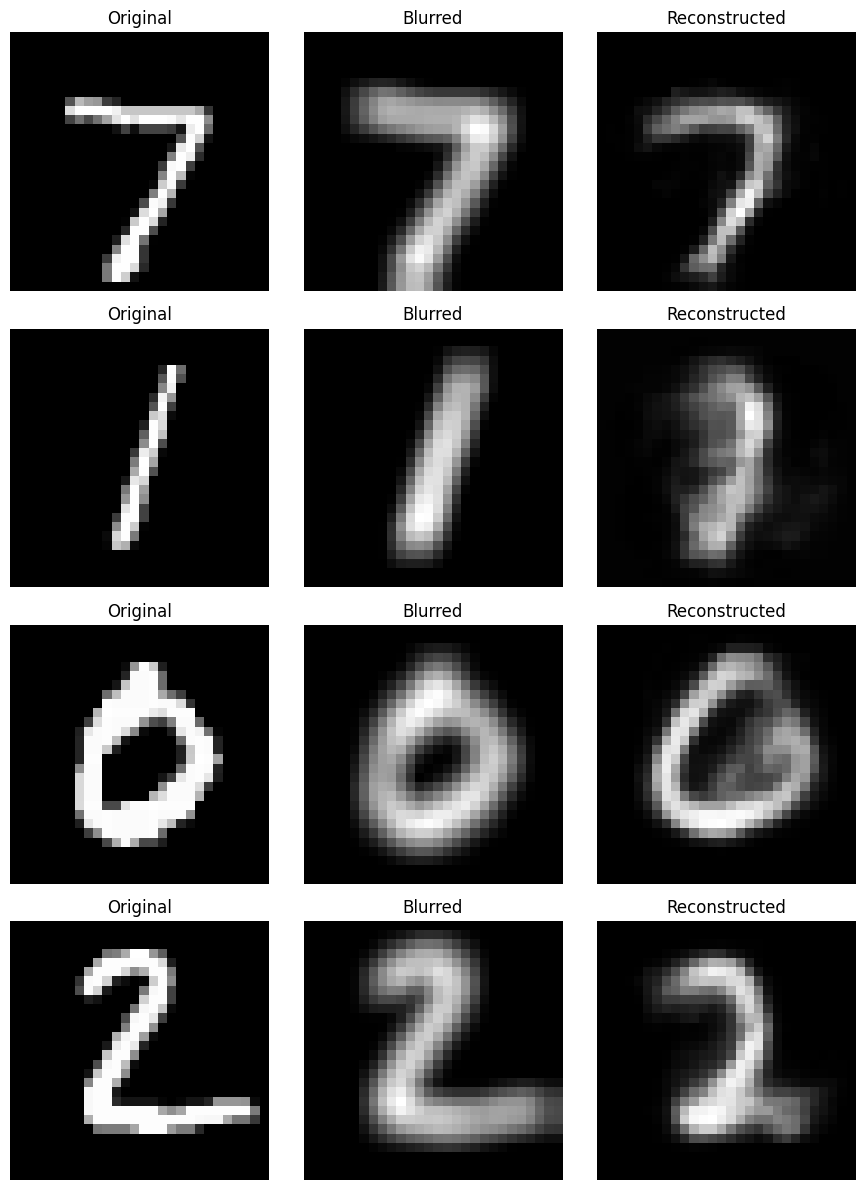

In [11]:
# experimenting with some blurred images

dataiter = iter(testloader)
images, _ = next(dataiter)
num_select = min(5, images.size(0))
indices = random.sample(range(images.size(0)), num_select)
selected_images = images[indices]
blurred_batch = torch.stack([TF.gaussian_blur(img, kernel_size=5, sigma=3.0) for img in selected_images]) # applying a moderate gaussian blur

model.eval()
with torch.no_grad():
    reconstructions = model(blurred_batch)

fig, axes = plt.subplots(num_select, 3, figsize=(9, 3 * num_select))
for i in range(num_select):
    axes[i, 0].imshow(selected_images[i].squeeze().numpy(), cmap="gray")
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")
    
    axes[i, 1].imshow(blurred_batch[i].squeeze().numpy(), cmap="gray")
    axes[i, 1].set_title("Blurred")
    axes[i, 1].axis("off")
    
    axes[i, 2].imshow(reconstructions[i].squeeze().numpy(), cmap="gray")
    axes[i, 2].set_title("Reconstructed")
    axes[i, 2].axis("off")
    
plt.tight_layout()
plt.show()